## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [76]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import norm

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [77]:
df = pd.read_csv('C:\\Users\\-\\Downloads\\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [78]:
num_rows = df.shape[0]
num_rows

294478

c. The number of unique users in the dataset.

In [79]:
unq_users = df['user_id'].nunique()
unq_users

290584

d. The proportion of users converted.

In [80]:
prp_conv = df['converted'].mean()*100
prp_conv

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

In [81]:
num_times1 = df.query('group == "treatment" and landing_page == "old_page"')['group'].count()
num_times2 = df.query('group == "control" and landing_page == "new_page"')['group'].count()
total = num_times1 + num_times2
total

3893

f. Do any of the rows have missing values?

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There is no missing values from the above.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [83]:
# drop rows where 'treatment' not aligned with 'new_page' and 'control' not aligned with 'old_page'
remove = df.query('group == "treatment" and landing_page == "old_page" or group == "control" and landing_page == "new_page"')
df2 = df.drop(remove.index)

In [84]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == "treatment") == (df2['landing_page'] == "new_page")) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [85]:
unq_users = df2['user_id'].nunique()
unq_users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [86]:
df2[df2['user_id'].duplicated()]['user_id'].unique()

array([773192], dtype=int64)

c. What is the row information for the repeat **user_id**? 

In [87]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [88]:
# drop row 2893
df2.drop(2893, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [89]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [90]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [91]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [92]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The old page is better than the new page **But** still there is no sufficient eivdence that the new treatment page leads to more conversions, And the probability of `control` group with the old page converted is **12%** , And the `treatment` group with the new page converted is **11.8%** which is less than the `control` group. We need to continue testing to reach conclusion.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$** : **$p_{new}$** $\leq$ **$p_{old}$**<br>

**$H_{1}$** : **$p_{new}$** $\gt$ **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [93]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [94]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [95]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$?

In [96]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [97]:
new_page_converted = np.random.binomial(1,p_new,n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [98]:
old_page_converted = np.random.binomial(1,p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [99]:
new_page_converted.mean() - old_page_converted.mean()

-0.00035993693068568644

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [100]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    pnew_pold = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(pnew_pold)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 1.0, 'Plot Simulate 10,000 values')

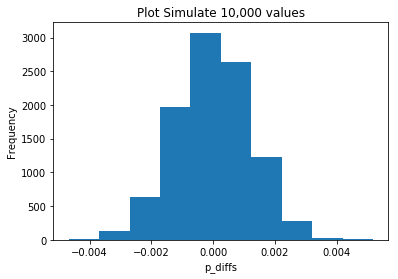

In [101]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot Simulate 10,000 values')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [102]:
# calculate the actual difference 
act_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
act_diffs

-0.0015782389853555567

In [103]:
# Convert p_diffs to array
p_diffs = np.array(p_diffs)

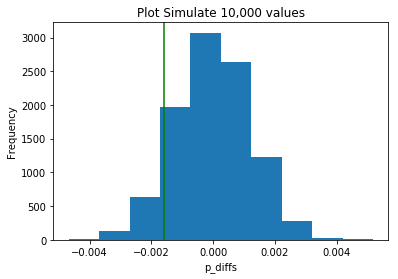

In [104]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot Simulate 10,000 values')
plt.axvline(act_diffs,color='green');

In [105]:
# Calculate the propotion of the p_diffs are greater than the actual difference observed in ab_data.csv 'compute p value'
(p_diffs > act_diffs).mean()

0.9028

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The value that we calculate it's called the **p-value**. <br>we learned how to make decisions based on p-values. if the p-value is less than our Type I error threshold,<br> then we have evidence to reject the null and choose the alternative.<br> Otherwise, we fail to reject the null hypothesis.<br>the p-value of observing the statistic given the Null is true.<br> As the p-value is large enough, we would fail to reject the Null hypothesis and keep the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [106]:
convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [107]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative='smaller')
z_score,p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [108]:
# (Tells us how significant our z-score is , Tells us what our critical value at 95% confidence is)
norm.cdf(z_score),norm.ppf(1-(0.05))

(0.9050583127590245, 1.6448536269514722)

Since the z-score of `1.3116075339133115` less than the critical value of `1.6448536269514722`, we fail to reject the null hypothesis ,The old page is the same or better than the new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [109]:
# create intercept column 
df2['intercept'] = 1
# create dummies
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [111]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [112]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        20:28:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

the p-value calculated using the z-score is higher than The p-value with ab_page column which is 0.19. They are different because the p-vlaue associated with ab_page calculated by two sided test, And the p-value with z-score was tested in one direction.

<br><br>
Hypotheses associated with our regression model:<br><br>
**$H_{0}$** : **$p_{new}$** $=$ **$p_{old}$** <br>

**$H_{1}$** : **$p_{new}$** $\neq $ **$p_{old}$**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


**When we consider other factors to add into our regression model it's good for multiple resons:**<br>
- Helps us to understand how much will the dependent variable change when we change the independent variables.

- The ability to determine the relative influence of one or more predictor variables to the criterion value.

- The ability to identify outliers, or anomalies.

- Predicts trends and future values. 

- Can be used to get point estimates.

- Makes our hypothesis results more reliable.

**The disadvantages to adding additional terms into our regression model:**
- The coefficient estimates can swing wildly based on which other independent variables are in the model. And become very sensitive to small changes in the model.

- Reduces the precision of the estimate coefficients, which weakens the statistical power of your regression model. We might not be able to trust the p-values to identify independent variables that are statistically significant.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [135]:
countries_df = pd.read_csv('C:\\Users\\-\\Downloads\\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [136]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [137]:
# create intercept column
df_new['intercept'] = 1

# Create the necessary dummy variables
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['country','CA'],axis=1)
df_new.head()

,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [138]:
df['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US', 'UK']])

In [139]:
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 20 Dec 2018   Pseudo R-squ.:               2.323e-05
Time:                        21:49:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [140]:
# interpret by exponentiate
np.exp(0.0408), np.exp(0.0506)

(1.0416437559600236, 1.0519020483004984)

In [141]:
# interpret the negtive by 1/np.exp
1/np.exp(-0.0149)

1.0150115583846535

#### Interpreting Conclusions:
- The p-value is larger in UK than US which means the users in UK are more converted than the users in US.

- The users from UK is `1.0519` times more likely to convert than the users from US.
- Conversion is `1.015` times as likely holding all else constant, For each unit decrease in new page.
- Conversion for US is `1.0416` times as likely holding all else constant, For each unit decrease in new page.
- The p-values do not provide a statistical basis to reject the null hypothesis and not significant, based on a Type I error rate of `5%`.

**all the p-values above are large there is no significant impact of the countries and new page on conversion rates.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [143]:
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

In [146]:
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK_ab_page','US_ab_page', 'UK', 'US']])


In [147]:
results = log_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Dec 2018   Pseudo R-squ.:               3.482e-05
Time:                        22:06:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
==============================================================================
"""

In [149]:
np.exp(results.params)

intercept     0.134794
ab_page       0.934776
UK_ab_page    1.081428
US_ab_page    1.048001
UK            1.011854
US            1.017682
dtype: float64

#### Interpreting Conclusions:

From the Logit Regression Results, the coefficient of intereaction variable UK_ab_page and US_ab_page are different from the coefficient of new page.

The intercept p-value < 0.05, which is statistically significant enough for converted rate.<br>
other varable in the summary are not statistically significant. and Z-score for all variables are not large enough to be significant for predicting converted rate.

- For every unit for new_page decreases, convert will be 7.0% more likely to happen, holding all other varible constant.

- the new page users and from UK is `1.08` times more likely to convert than CA and new page users, holding all other varible constant.

- the new page users and from US is `1.04` times more likely to convert than CA and new page users, holding all other varible constant.

- The users from UK is `1.011` times more likely to convert than the users from CA. holding all other varible constant.

- The users from US is `1.017` times more likely to convert than the users from CA. holding all other varible constant.



There is no significant effect for the country of the user and converted rate considering the page the user land in.

<a id='conclusions'></a>
## Conclusions
We performed an AB test first we similating from the Null then calculating the Z-score. we get the same conclusion of retaining the null hypothesis : landing page do not have sigificant effect on the converted rate.<br>

Then we regression approach by fitting a logistic regression model. Although the p-value is different from what we got in the AB test due to different null and alternative hypotheses, the result provided by the regression model agreed with the results in the AB test.<br>

Finally, we introduced an additional factor into the regression model for avoid the situation in Simpson's Paradox, which is the country a user lives. We looked at the individual factors and the interaction of country and landing page to see if they have significant effects on conversion. The results showed that the factors of landing page and country do not lead to significant effect on the converted rate individually as well as interactively.

In the end of our analysis we found that the old page is better than the new page , so we fail to reject the null hypothesis.

**We recommend the company to continue with the old page.**.


### Resources

[R1](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html), 
[R2](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html), 
[R3](https://stackoverflow.com/questions/11587782/creating-dummy-variables-in-pandas-for-python), 
